In [1]:
import zarr
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from rich import print
from pathlib import Path
from omegaconf import OmegaConf
from dataclasses import dataclass
from alive_progress import alive_it
from sortedcontainers import SortedList
from walrus_workshop.utils import get_key_value_from_string
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.model import load_sae
from walrus_workshop.metrics import compute_enstrophy, compute_deformation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


In [2]:
@dataclass
class Feature:
    index: int
def plot_feature(feature, data_chunk, with_simulation=False, verbose=False, simulation_field=0):
    """ Plot feature """
    if verbose:
        print(f"Plotting feature {feature.index}")
    activations = data_chunk.code[:, feature.index].reshape(-1, 32, 32)
    vmax = np.max(np.abs(activations))
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    for i in range(data_chunk.n_timesteps):
        ax = axs[i // 3, i % 3]
        cb = ax.imshow(activations[i], cmap='hot', vmin=0, vmax=vmax)
        fig.colorbar(cb, ax=ax, shrink=0.5)
        if with_simulation:
            ax.contour(np.linspace(-0.5, activations.shape[1]+0.5, data_chunk.simulation.shape[2]), 
            np.linspace(-0.5, activations.shape[2]+0.5, data_chunk.simulation.shape[1]), 
            data_chunk.simulation[i, ..., simulation_field], levels=1, colors='lavender')
        # ax.set_title(f"Step {data_chunk.step + i}"); ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    plt.show()

In [3]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trajectory
trajectory_id = 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

## Significance

In [4]:
# List of interesting features from the first 
feature_list = [Feature(index=3809), Feature(index=7130), Feature(index=8594), Feature(index=14056), Feature(469)]

## Deformation

In [5]:
step_index = 3
step = steps[step_index]
print(f"Step index {step_index} = step {step}")

Step index 3 = step 11

Opening activation file step_0011_traj_50_Reynolds_1e+05_Schmidt_5e-01_layerblocks.20.space_mixing.activation

Simulation chunk shape: torch.Size([6, 256, 512, 5])

Total deformation

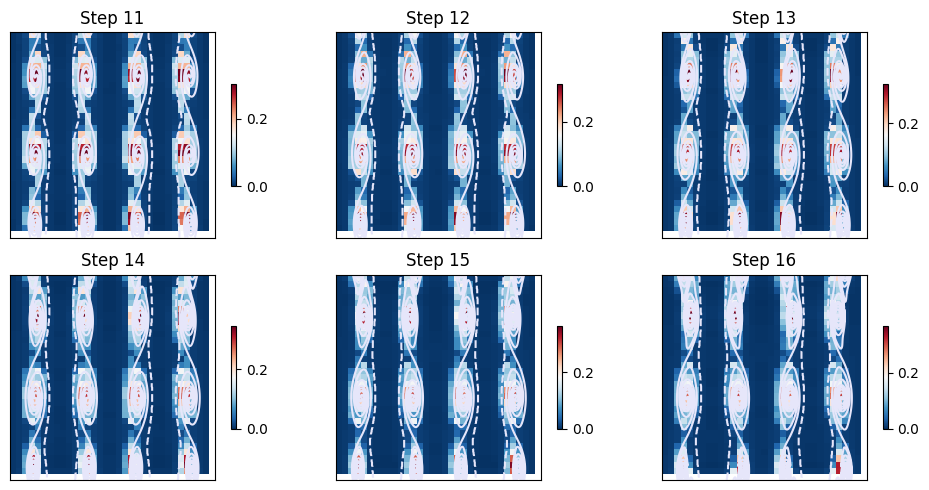

In [6]:
@dataclass
class DataChunk:
    step: int
    n_features: int
    n_timesteps: int
    simulation: np.ndarray
    code: np.ndarray
    total_deformation: np.ndarray


# Get SAE features
print(f"Opening activation file {Path(act_files[step_index]).stem}")
assert get_key_value_from_string(Path(act_files[step_index]).stem, "step") == step # make sure we are processing the same step
act = zarr.open(act_files[step_index], mode="r")
act = torch.from_numpy(np.array(act)).to(device)
with torch.no_grad():
    _, code, _ = sae_model(act)
code = code.cpu().numpy()

# Get simulation chunk
simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input, :, :, 0, :]
print(f"Simulation chunk shape: {simulation_chunk.shape}")

scale_x = int(simulation_chunk.shape[2] / 32)  # width
scale_y = int(simulation_chunk.shape[1] / 32)  # height
total_deformation = np.zeros((simulation_chunk.shape[0], 32, 32)) # 32x32 grid of total deformation

for i in range(simulation_chunk.shape[0]):
    for ix in range(32):
        for iy in range(32):
            token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
            total_deformation[i, iy, ix] = np.sqrt(np.mean(compute_deformation(token[:, :, 2], token[:, :, 3])[0]))

data_chunk = DataChunk(step=step, n_features=code.shape[1], n_timesteps=simulation_chunk.shape[0], simulation=simulation_chunk, code=code, total_deformation=total_deformation)

print("Total deformation")
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i in range(data_chunk.n_timesteps):
    ax = axs[i // 3, i % 3]
    vmax = np.max(np.abs(data_chunk.total_deformation[i]))
    cb = ax.imshow(data_chunk.total_deformation[i], cmap="RdBu_r", vmin=0, vmax=vmax)
    fig.colorbar(cb, ax=ax, shrink=0.5)
    ax.set_title(f"Step {step + i}"); ax.set_xticks([]); ax.set_yticks([])

    ax.contour(np.linspace(-0.5, data_chunk.total_deformation.shape[1]+0.5, data_chunk.simulation.shape[2]), 
        np.linspace(-0.5, data_chunk.total_deformation.shape[2]+0.5, data_chunk.simulation.shape[1]), 
        data_chunk.simulation[i, ..., 0], levels=1, colors='lavender')        
fig.tight_layout()
plt.show()

In [7]:
# Compute deformation
total_def_flat = data_chunk.total_deformation.ravel()

# Screen features
n_features = data_chunk.code.shape[1]
correlation = np.full(n_features, np.nan)
mean_def_active = np.full(n_features, np.nan)
mean_def_inactive = np.full(n_features, np.nan)
selectivity = np.full(n_features, np.nan)

global_mean_def = np.mean(total_def_flat)

for feature in alive_it(range(n_features), force_tty=True):
    activations = data_chunk.code[:, feature]
    mask = activations > 0
    n_active = np.sum(mask)
    
    if n_active > 30 and n_active < len(mask) - 30:
        act_masked = activations[mask]
        def_when_active = total_def_flat[mask]
        def_when_inactive = total_def_flat[~mask]
        
        # Correlation: does activation magnitude predict deformation?
        correlation[feature] = np.corrcoef(act_masked, def_when_active)[0, 1]
        
        # Mean deformation when active vs inactive
        mean_def_active[feature] = np.mean(def_when_active)
        mean_def_inactive[feature] = np.mean(def_when_inactive)
        
        # Selectivity: how much more deformation where feature is active?
        selectivity[feature] = mean_def_active[feature] / mean_def_inactive[feature]

@dataclass
class DeformationFeature:
    index: int
    selectivity: float
    correlation: float

    def __lt__(self, other):
        return self.selectivity > other.selectivity # reversed so greatest selectiving is first when using SortedList

feature_list = SortedList()
# Create feature_list sorted by selectivy
for i in range(n_features):
    if np.isfinite(selectivity[i]):
        feature_list.add(DeformationFeature(index=i, selectivity=selectivity[i], correlation=correlation[i]))

# Print top 10 features
print("Top 10 features by selectivity:")
for feature in feature_list[:10]:
    print(f"  Feature {feature.index}: selectivity={feature.selectivity:.2f}, "
          f"corr={feature.correlation:.3f}")

|                                        | ▁▃▅ 0/22528 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 22528/22528 [100%] in 2.1s (11005.73/


Top 10 features by selectivity:

Feature 3809: selectivity=5.76, corr=0.325

Feature 7130: selectivity=5.69, corr=0.143

Feature 8594: selectivity=5.65, corr=0.375

Feature 14056: selectivity=5.60, corr=0.117

Feature 469: selectivity=5.58, corr=0.237

Feature 13053: selectivity=5.52, corr=0.246

Feature 13657: selectivity=5.43, corr=-0.113

Feature 10246: selectivity=5.39, corr=0.301

Feature 5714: selectivity=5.37, corr=0.301

Feature 18771: selectivity=5.15, corr=0.332

In [ ]:
# feature_list = [Feature(index=3809), Feature(index=7130), Feature(index=8594)]

Plotting feature 3809

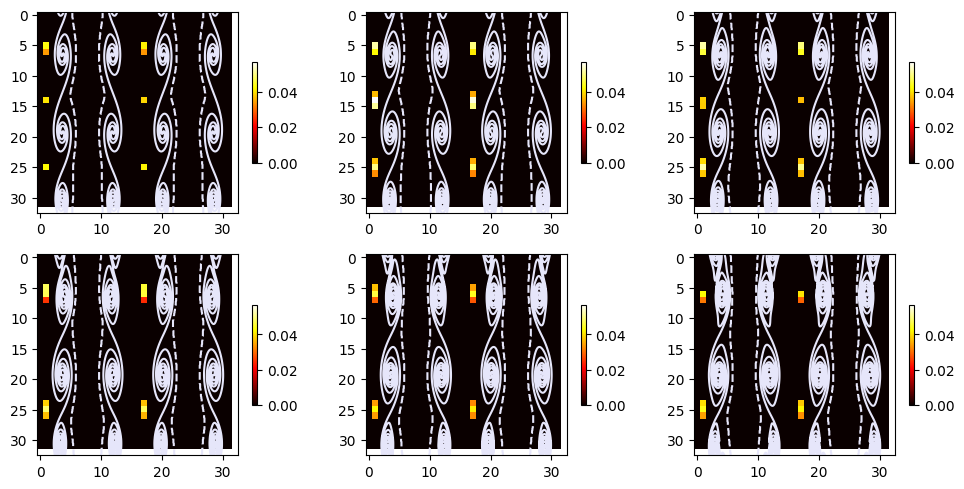

In [7]:
plot_feature(feature_list[0], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

Plotting feature 7130

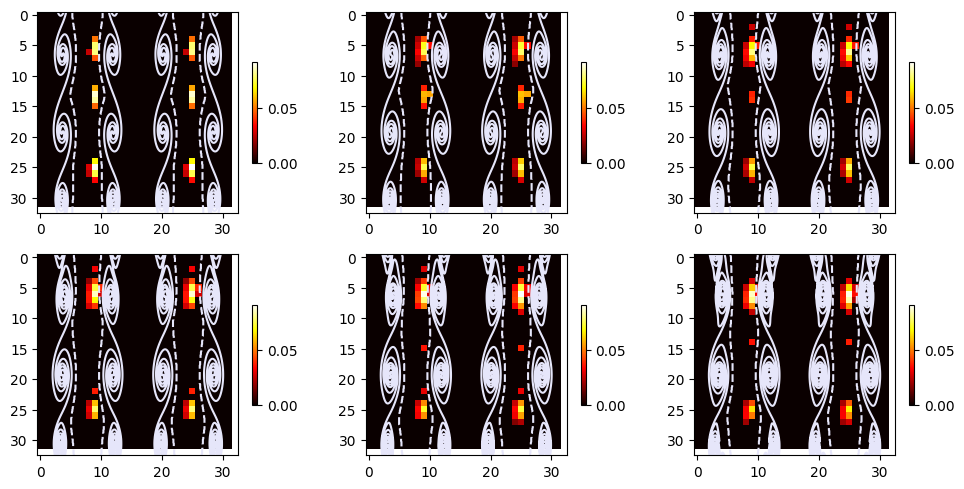

In [8]:
plot_feature(feature_list[1], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

Plotting feature 8594

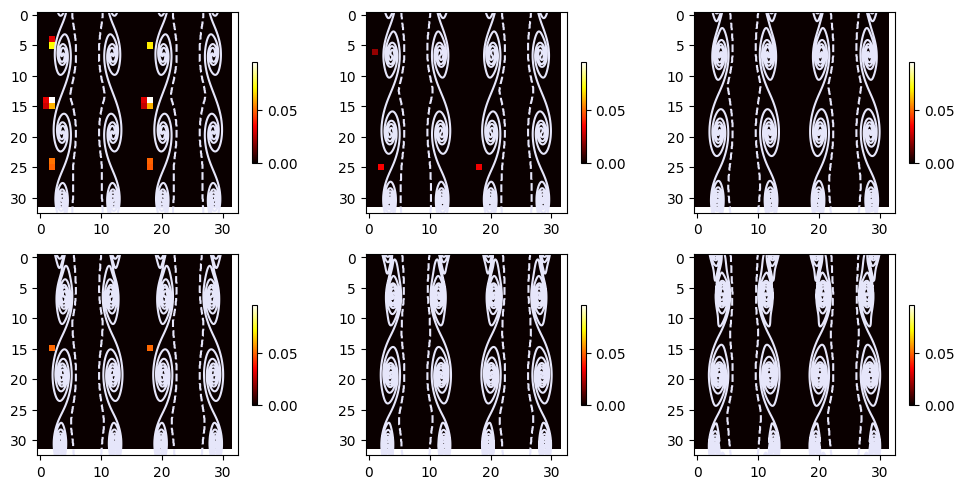

In [9]:
plot_feature(feature_list[2], data_chunk, verbose=True, with_simulation=True, simulation_field=0)

## Enstrophy Derivative

In [ ]:
@dataclass
class DataChunk:
    step: int
    n_features: int
    simulation: np.ndarray
    code: np.ndarray
    enstrophy: np.ndarray
    vorticity: np.ndarray
    dEdt: np.ndarray

# Get SAE features
print(f"Opening activation file {Path(act_files[step_index]).stem}")
assert get_key_value_from_string(Path(act_files[step_index]).stem, "step") == step # make sure we are processing the same step
act = zarr.open(act_files[step_index], mode="r")
act = torch.from_numpy(np.array(act)).to(device)
with torch.no_grad():
    _, code, _ = sae_model(act)
code = code.cpu().numpy()

# Get simulation chunk
simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
print(f"Simulation chunk shape: {simulation_chunk.shape}")

scale_x = int(simulation_chunk.shape[2] / 32)  # width
scale_y = int(simulation_chunk.shape[1] / 32)  # height
enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32)) # 32x32 grid of enstrophy

# Calulate vorticity and dEdt
vorticity = []
dEdt = []
for i in range(simulation_chunk.shape[0]):
    for ix in range(32):
        for iy in range(32):
            token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
            enstrophy[i, iy, ix] = compute_enstrophy(token[:, :, 2], token[:, :, 3])[0]
    e, v = compute_enstrophy(simulation_chunk[i, :, :, 2], simulation_chunk[i, :, :, 3])
    vorticity.append(v)
    dEdt.append(e)
vorticity = np.array(vorticity[:-1])
dEdt = np.array(dEdt[:-1])
dEdt = -1*np.diff(enstrophy, axis=0)
print(f"Vorticity shape: {vorticity.shape}")
print(f"dEdt shape: {dEdt.shape}")

data_chunk = DataChunk(step=step, n_features=code.shape[1], simulation=simulation_chunk[:-1], code=code, enstrophy=enstrophy, vorticity=vorticity, dEdt=dEdt)


Opening activation file step_0005_traj_50_Reynolds_1e+05_Schmidt_5e-01_layerblocks.20.space_mixing.activation

Simulation chunk shape: torch.Size([7, 256, 512, 5])

Vorticity shape: (6, 256, 512)

dEdt shape: (6, 32, 32)

Plotting vorticity

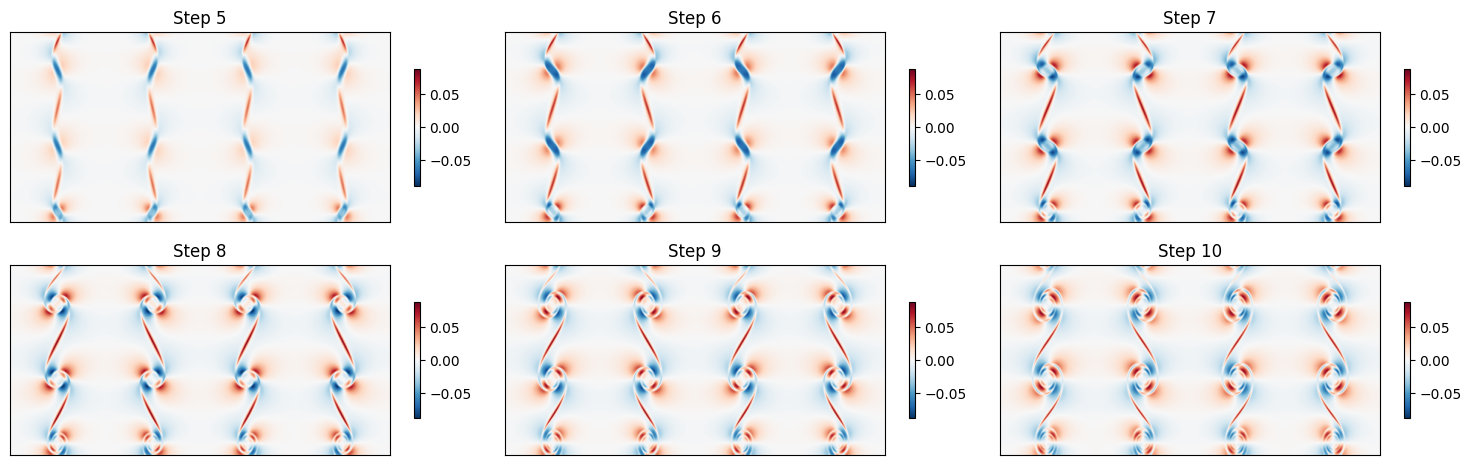

In [ ]:
print("Plotting vorticity")
fig, axes = plt.subplots(2, 3, figsize=(15, 5))
vmax = np.max(np.abs(data_chunk.vorticity))
for i in range(data_chunk.vorticity.shape[0]):
    ax = axes[i // 3, i % 3]
    cb = ax.imshow(data_chunk.vorticity[i], cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    fig.colorbar(cb, ax=ax, shrink=0.5)
    ax.set_title(f"Step {step + i}"); ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

|████████████████████████████████████████| 22528/22528 [100%] in 1.8s (12510.88/


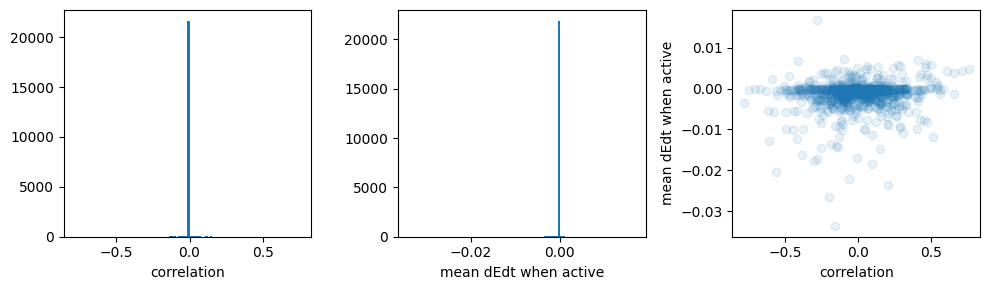

In [ ]:
correlations = np.zeros(data_chunk.n_features)
mean_dEdt_when_active = np.zeros(data_chunk.n_features)

dEdt_flat = data_chunk.dEdt.ravel()

for feature in alive_it(range(data_chunk.code.shape[1]), force_tty=True):
    activations = data_chunk.code[:, feature]
    mask = activations > 0
    
    if np.sum(mask) > 30:  # require minimum samples
        # Correlation between activation magnitude and dEdt (when active)
        act_masked = activations[mask]
        dEdt_masked = dEdt_flat[mask]
        
        correlations[feature] = np.corrcoef(act_masked, dEdt_masked)[0, 1]
        mean_dEdt_when_active[feature] = np.mean(dEdt_masked)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].hist(correlations, bins=100);
axes[0].set_xlabel('correlation')
axes[1].hist(mean_dEdt_when_active, bins=100);
axes[1].set_xlabel('mean dEdt when active')
axes[2].scatter(correlations, mean_dEdt_when_active, alpha=0.1);
axes[2].set_xlabel('correlation')
axes[2].set_ylabel('mean dEdt when active')
fig.tight_layout()
plt.show()


on 217: /tmp/ipykernel_1456117/2838191509.py:6: RuntimeWarning: divide by zero encountered in divide
          z_score = (activations - np.mean(activations[mask])) / np.std(activations[mask])
        /tmp/ipykernel_1456117/2838191509.py:6: RuntimeWarning: invalid value encountered in divide
          z_score = (activations - np.mean(activations[mask])) / np.std(activations[mask])


|▉                                       | ▃▅▇ 505/22528 [2%] in 0s (~2s, 10602.

|████████████████████████████████████████| 22528/22528 [100%] in 2.1s (10936.84/


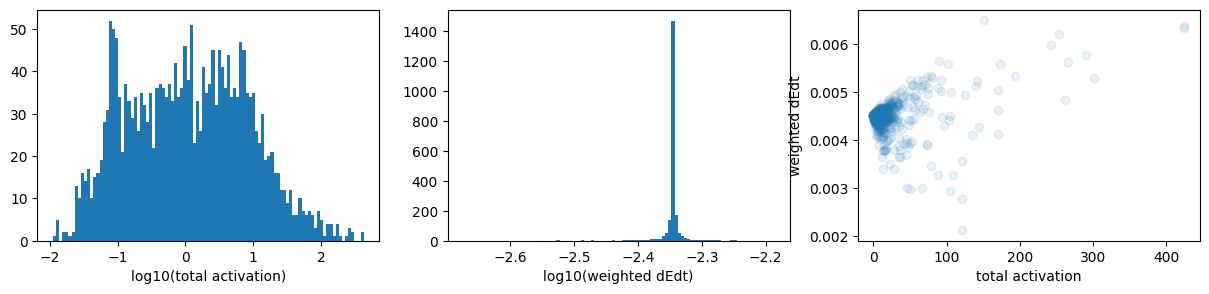

In [ ]:
weighted_dEdt = np.zeros(data_chunk.n_features)
for feature in alive_it(range(data_chunk.code.shape[1]), force_tty=True):
    activations = data_chunk.code[:, feature]
    if np.any(activations != 0):
        mask = activations > 0
        z_score = (activations[mask] - np.mean(activations[mask])) / np.std(activations[mask])
        weighted_dEdt[feature] = np.sum(np.abs(data_chunk.dEdt.ravel()) * z_score) / np.sum(z_score)

mask = weighted_dEdt != 0
weighted_dEdt = weighted_dEdt[mask]
activations = np.sum(data_chunk.code, axis=0)
assert np.all(mask == (activations > 0))
activations = activations[mask]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].hist(np.log10(activations), bins=100);
axes[0].set_xlabel('log10(total activation)')
axes[1].hist(np.log10(np.abs(weighted_dEdt)), bins=100);
axes[1].set_xlabel('log10(weighted dEdt)')
axes[2].scatter(activations, weighted_dEdt, alpha=0.1);
axes[2].set_xlabel('total activation')
axes[2].set_ylabel('weighted dEdt')
plt.show()



